In [2]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from coffea import hist, processor 
from coffea.hist import plot
from coffea.util import load

In [3]:
hists = load('hists/darkhiggs2018.scaled')

In [4]:
process = hist.Cat("process", "Process", sorting='placement')
cats = ("process",)

In [66]:
map = OrderedDict()
map["Hbb_merged"] = ("Hbb_merged*")
map["Hbb_unmerged"] = ("Hbb_unmerged*")
map["DYJetsHF"] = ("DYJetsHF*",)
map["DYJetsLF"] = ("DYJetsLF*",)
map["VVqq"] = ("VVqq*",)
map["VVbb"] = ("VVbb*",)
map["VVother"] = ("VVother*",)
map["STbqq"] = ("STbqq*",)
map["STqq"] = ("STqq*",)
map["STother"] = ("STother*",)
map["TTbqq"] = ("TTbqq*",)
map["TTqq"] = ("TTqq*",)
map["TTother"] = ("TTother*",)
map["WJetsHF"] = ("WJetsHF*",)
map["WJetsLF"] = ("WJetsLF*",)
map["ZJetsHF"] = ("ZJetsHF*",)
map["ZJetsLF"] = ("ZJetsLF*",)
map["GJetsHF"] = ("GJetsHF*",)
map["GJetsLF"] = ("GJetsLF*",)
map["QCD"] = ("QCD*",)
bkg_hists = {}
for key in hists.keys():                                                                                                                            
    bkg_hists[key] = hists[key].group(cats, process, map)  

In [6]:
map = OrderedDict()
map["Mhs_50_merged"] = ("Mhs_50_merged*",)  ## signals
map["Mhs_50_unmerged"] = ("Mhs_50_unmerged*",)  ## signals   
map["Mhs_70_merged"] = ("Mhs_70_merged*",)
map["Mhs_70_unmerged"] = ("Mhs_70_unmerged*",)
map["Mhs_90_merged"] = ("Mhs_90_merged*",)
map["Mhs_90_unmerged"] = ("Mhs_90_unmerged*",)
map["MonoJet"] = ("MonoJet*",)  ## signals
map["MonoW"] = ("MonoW*",)    ## signals
map["MonoZ"] = ("MonoZ*",)    ## signals
signal_hists = {}
for key in hists.keys():                                                                                                                            
    signal_hists[key] = hists[key].group(cats, process, map)

In [31]:
map = OrderedDict()
map["MET"] = ("MET*", )
map["SingleElectron"] = ("SingleElectron*", )
map["SinglePhoton"] = ("SinglePhoton*", )
data_hists = {}
for key in hists.keys():                                                                                                                            
    data_hists[key] = hists[key].group(cats, process, map)

In [68]:
exp = 0
region = 'wmcr'
sys = 'nominal'
data={}
data['sr'] = 'MET'
data['wmcr'] = 'MET'
data['tmcr'] = 'MET'
data['wecr'] = 'SingleElectron'
data['tecr'] = 'SingleElectron'
data['zmcr'] = 'MET'
data['zecr'] = 'SingleElectron'
data['gcr'] = 'SinglePhoton'

variable = 'met'
cut_bin = 0
nbins = data_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', 'MET').values(overflow='all')[()].size
cut_value_array = data_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', 'MET').axis(variable).edges(overflow='all')

print('------------------------')
print('------------------------')
print('Category:', region)
print('Systematic:', sys)
#print('------------------------')
if cut_bin!=0: print(variable,'> %.2f' % cut_value_array[()][cut_bin])
print('------------------------')
print('------------------------')
for p in bkg_hists[variable].identifiers('process'):
    yld_array = bkg_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', p).values(overflow='all')
    if () in yld_array:
        yld = np.cumsum(yld_array[()])[nbins-1] - np.cumsum(yld_array[()])[cut_bin]
        exp += yld
        print(p, '%.1f' % yld)

print('------------------------')
print('Total expected:', '%.1f' % exp)
print('------------------------')

for p in signal_hists[variable].identifiers('process'):
    yld_array = signal_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', p).values(overflow='all')
    if () in yld_array:
        yld = np.cumsum(yld_array[()])[nbins-1] - np.cumsum(yld_array[()])[cut_bin]
        print(p, '%.1f' % yld)
        print(p,'S/B %.3f' % (yld/exp))
        print(p,'S/sqrt(B) %.1f' % (yld/np.sqrt(exp)))
        #print(p,'Fraction %.2f' % (yld/np.cumsum(yld_array[()])[16]))
        print('------------------------')

if not region == 'sr':
    yld_array = data_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', data[region.split('_')[0]]).values(overflow='all')
    if () in yld_array and 'iszeroL' not in region:
        yld = np.cumsum(yld_array[()])[nbins-1] - np.cumsum(yld_array[()])[cut_bin]
        print('Total observed:', '%.1f' % yld)   
print('------------------------')
print()

------------------------
------------------------
Category: wmcr
Systematic: nominal
------------------------
------------------------
Hbb_merged 80.4
Hbb_unmerged 30.8
DYJetsHF 1108.8
DYJetsLF 12552.4
VVqq 4564.2
VVbb 144.1
VVother 4851.7
STbqq 3121.4
STqq 708.1
STother 6937.3
TTbqq 14013.4
TTqq 3556.6
TTother 13616.0
WJetsHF 60115.2
WJetsLF 294611.4
QCD 15663.3
------------------------
Total expected: 435675.3
------------------------
Total observed: 428578.0
------------------------



In [70]:
#Calculating pass/fail efficiencies 
pass_eff={}
num={}
den={}
for p in bkg_hists['recoil'].identifiers('process'):
    if () not in bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process', p).values(): continue
    vnum = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','sr_monohs').integrate('process', p).values()[()].sum()
    vden = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process', p).values()[()].sum()
    pass_eff[str(p)]=vnum/vden
print(pass_eff)

{'Hbb_merged': 0.9042409559282618, 'Hbb_unmerged': 0.47432545975850104, 'DYJetsHF': 0.2849193272904102, 'DYJetsLF': 0.06665329428181156, 'VVqq': 0.11985420607971677, 'VVbb': 0.8706902930787168, 'VVother': 0.08942983624446428, 'STbqq': 0.6427827085225926, 'STqq': 0.15969916156539485, 'STother': 0.3464592658059867, 'TTbqq': 0.611248299176516, 'TTqq': 0.14597294473306902, 'TTother': 0.5148275108793459, 'WJetsHF': 0.13980033489034388, 'WJetsLF': 0.06155419296343934, 'ZJetsHF': 0.3140282026474058, 'ZJetsLF': 0.05120554461677078, 'QCD': 0.13331657234318897}


In [58]:
map = OrderedDict()
map["Hbb_merged"] = ("Hbb_merged*")
map["Hbb_unmerged"] = ("Hbb_unmerged*")
map["Hbb"] = ("Hbb*")
map["DYJetsHF"] = ("DYJetsHF*",)
map["DYJetsLF"] = ("DYJetsLF*",)
map["DYJets"] = ("DYJets*",)
map["VVqq"] = ("VVqq*",)
map["VVbb"] = ("VVbb*",)
map["VVother"] = ("VVother*",)
map["VV"] = ("VV*",)
map["STbqq"] = ("STbqq*",)
map["STqq"] = ("STqq*",)
map["STother"] = ("STother*",)
map["ST"] = ("ST*",)
map["TTbqq"] = ("TTbqq*",)
map["TTqq"] = ("TTqq*",)
map["TTother"] = ("TTother*",)
map["TT"] = ("TT*",)
map["WJetsHF"] = ("WJetsHF*",)
map["WJetsLF"] = ("WJetsLF*",)
map["WJets"] = ("WJets*",)
map["ZJetsHF"] = ("ZJetsHF*",)
map["ZJetsLF"] = ("ZJetsLF*",)
map["ZJets"] = ("ZJets*",)
map["GJetsHF"] = ("GJetsHF*",)
map["GJetsLF"] = ("GJetsLF*",)
map["GJets"] = ("GJets*",)
map["QCD"] = ("QCD*",)
bkg_hists = {}
for key in hists.keys():                                                                                                                            
    bkg_hists[key] = hists[key].group(cats, process, map)  

In [57]:
#calculating AK4 b-tagging rate efficiencies per process in each recoil bin
#number of recoil bins in each mass bin

binning = {
    'mass0': data_hists['recoil'].integrate('systematic','nominal').integrate('region','sr_mass0').integrate('process','MET').axis('recoil').edges(),
    'mass1': data_hists['recoil'].integrate('systematic','nominal').integrate('region','sr_mass1').integrate('process','MET').axis('recoil').edges(),
    'mass2': data_hists['recoil'].integrate('systematic','nominal').integrate('region','sr_mass2').integrate('process','MET').axis('recoil').edges(),
    'mass3': data_hists['recoil'].integrate('systematic','nominal').integrate('region','sr_mass3').integrate('process','MET').axis('recoil').edges(),
    'mass4': data_hists['recoil'].integrate('systematic','nominal').integrate('region','sr_mass4').integrate('process','MET').axis('recoil').edges()
}
print(binning)
efficiencies_dict = {}
for p in bkg_hists['recoil'].identifiers('process'):
    efficiencies_dict[str(p)]={}
    hwmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p)#.values()#(overflow='all')
    hwecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p)#.values()#(overflow='all')
    htmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p)#.values()#(overflow='all')
    htecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p)#.values()#(overflow='all')
    for mass in binning.keys():
        wmcr = hwmcr.rebin('recoil',hist.Bin('recoil','Hadronic recoil',binning[mass])).values()
        wecr = hwecr.rebin('recoil',hist.Bin('recoil','Hadronic recoil',binning[mass])).values()
        tmcr = htmcr.rebin('recoil',hist.Bin('recoil','Hadronic recoil',binning[mass])).values()
        tecr = htecr.rebin('recoil',hist.Bin('recoil','Hadronic recoil',binning[mass])).values()
        if () in wmcr: 
            efficiencies_dict[str(p)][mass] = np.nan_to_num((wmcr[()]+wecr[()])/(wmcr[()]+wecr[()]+tmcr[()]+tecr[()]))

print(efficiencies_dict)

{'mass0': array([ 250.,  280.,  310.,  340.,  370.,  400.,  430.,  470.,  510.,
        550.,  590.,  640.,  690.,  740.,  790.,  840.,  900.,  960.,
       1020., 1090., 1160., 1250.]), 'mass1': array([ 250.,  280.,  310.,  340.,  370.,  400.,  430.,  470.,  510.,
        550.,  590.,  640.,  690.,  740.,  790.,  840.,  900.,  960.,
       1020., 1090., 1160., 1250.]), 'mass2': array([ 250.,  280.,  310.,  340.,  370.,  400.,  430.,  470.,  510.,
        550.,  590.,  640.,  690.,  740.,  790.,  840.,  900.,  960.,
       1020., 1090., 1160., 1250.]), 'mass3': array([ 250.,  280.,  310.,  340.,  370.,  400.,  430.,  470.,  510.,
        550.,  590.,  640.,  690.,  740.,  790.,  840.,  900.,  960.,
       1020., 1090., 1160., 1250.]), 'mass4': array([ 250.,  280.,  310.,  340.,  370.,  400.,  430.,  470.,  510.,
        550.,  590.,  640.,  690.,  740.,  790.,  840.,  900.,  960.,
       1020., 1090., 1160., 1250.])}
Hbb_merged
Hbb_unmerged
DYJetsHF
DYJetsLF
VVqq
VVbb
VVother
STbqq
STq

/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/mplhep/__init__.py:49: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)
/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/coffea/hist/plot.py:359: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/coffea/hist/plot.py:366: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/coffea/hist/plot.py:380: Run

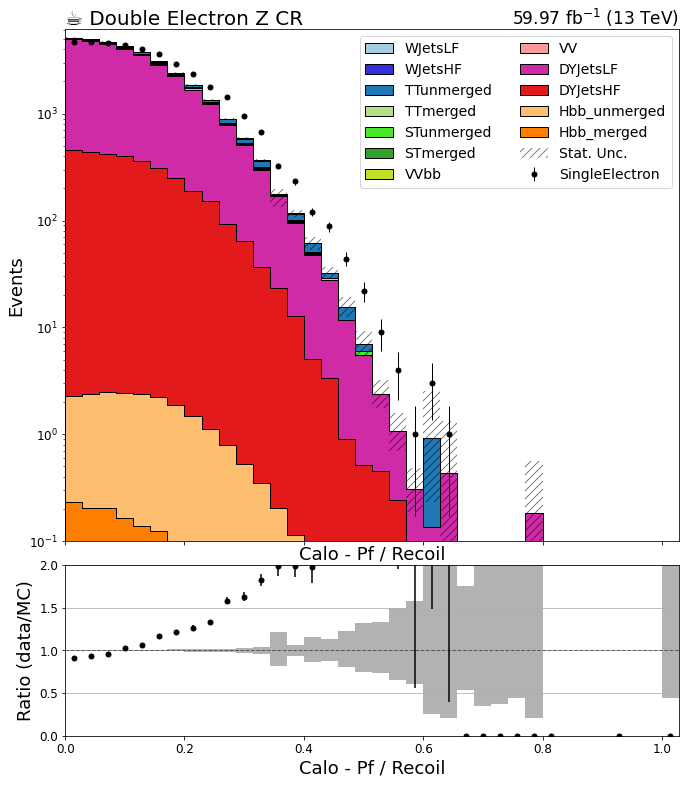

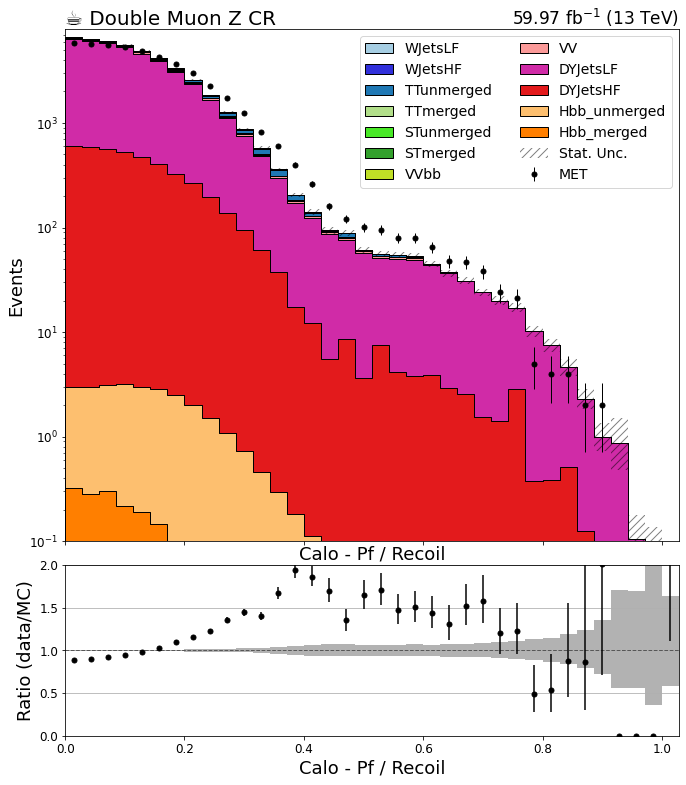

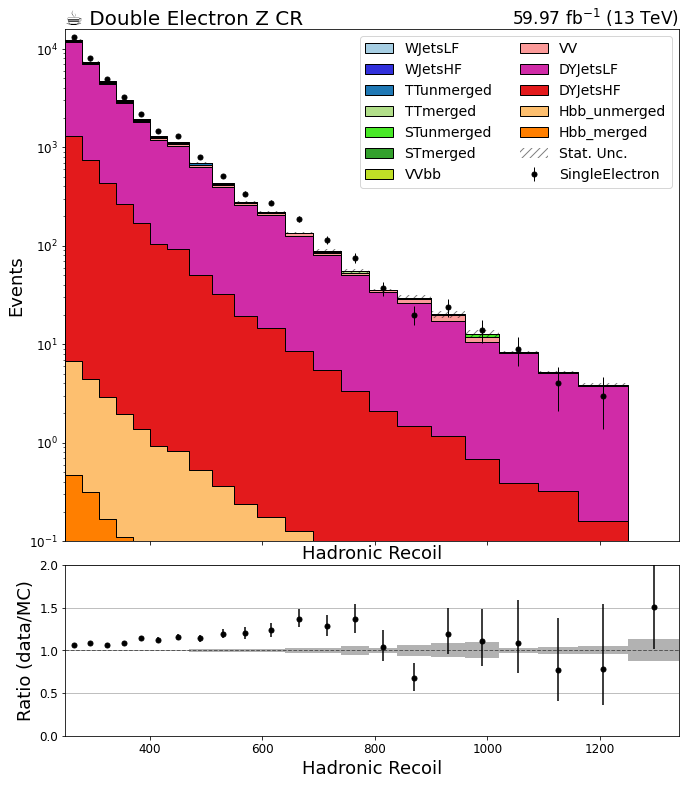

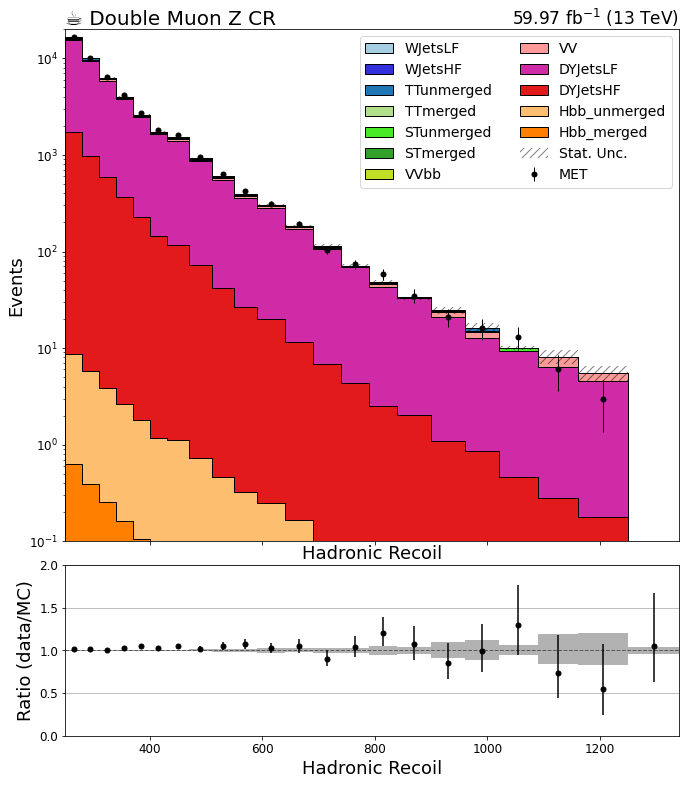

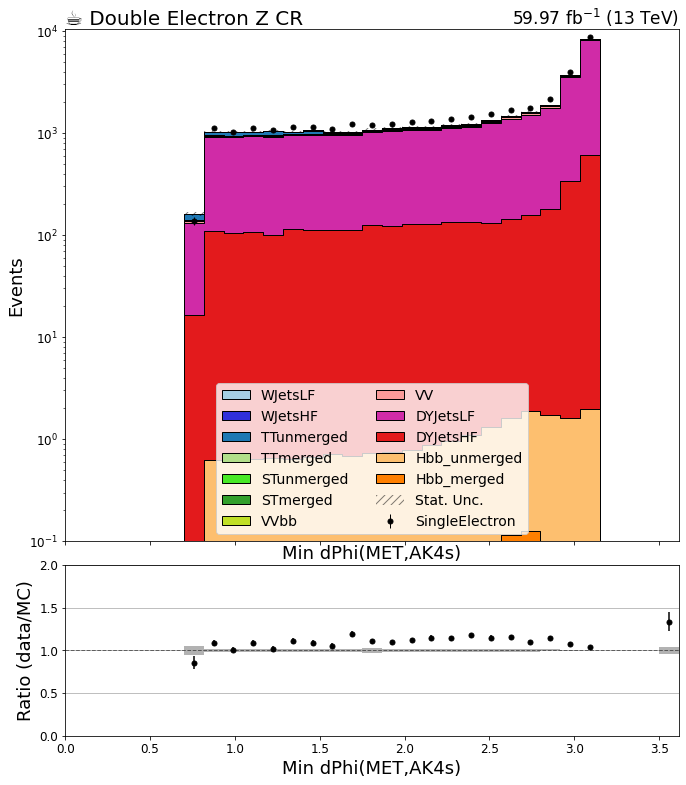

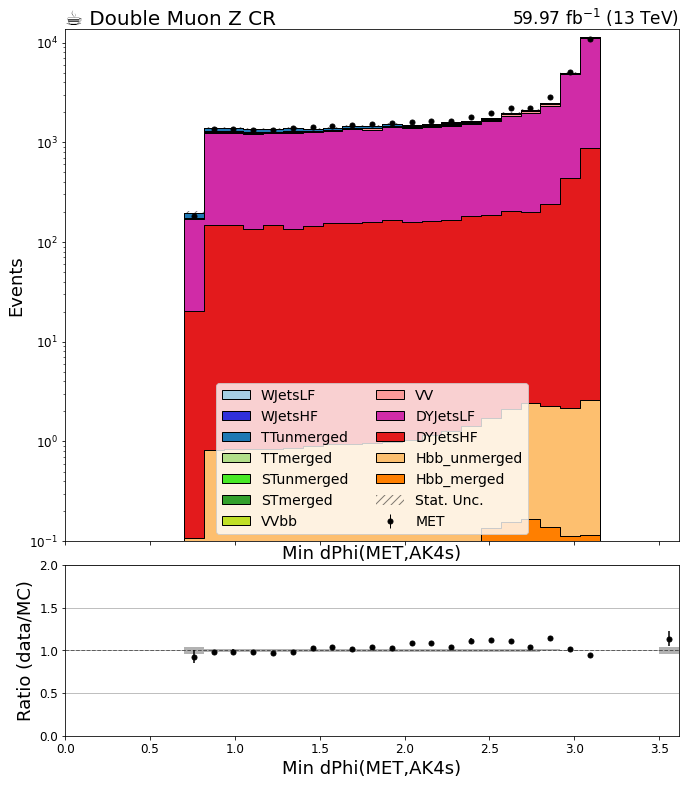

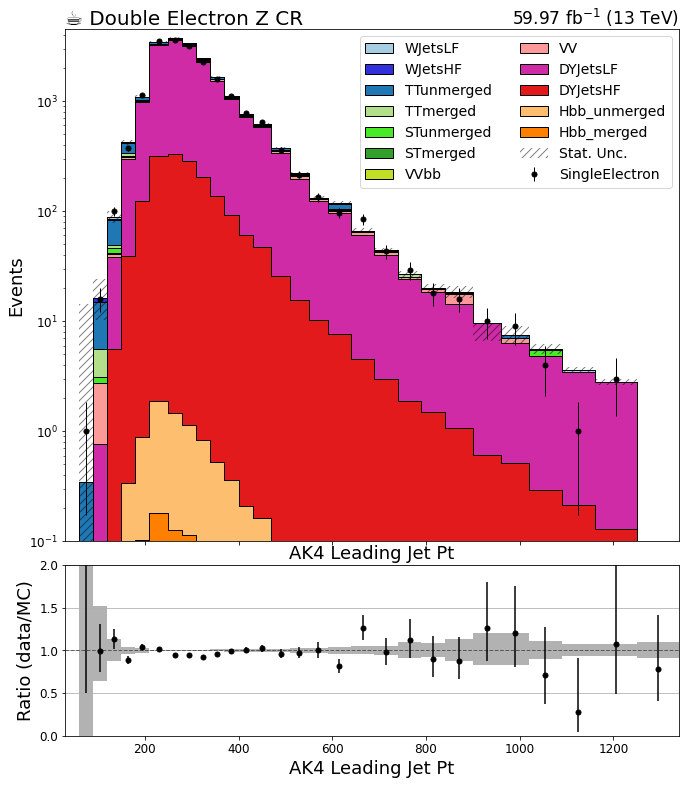

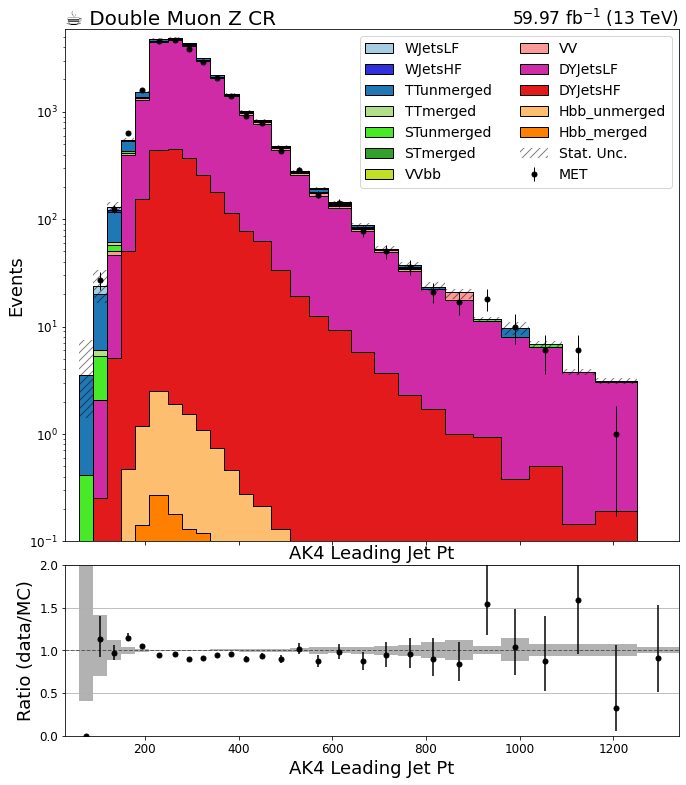

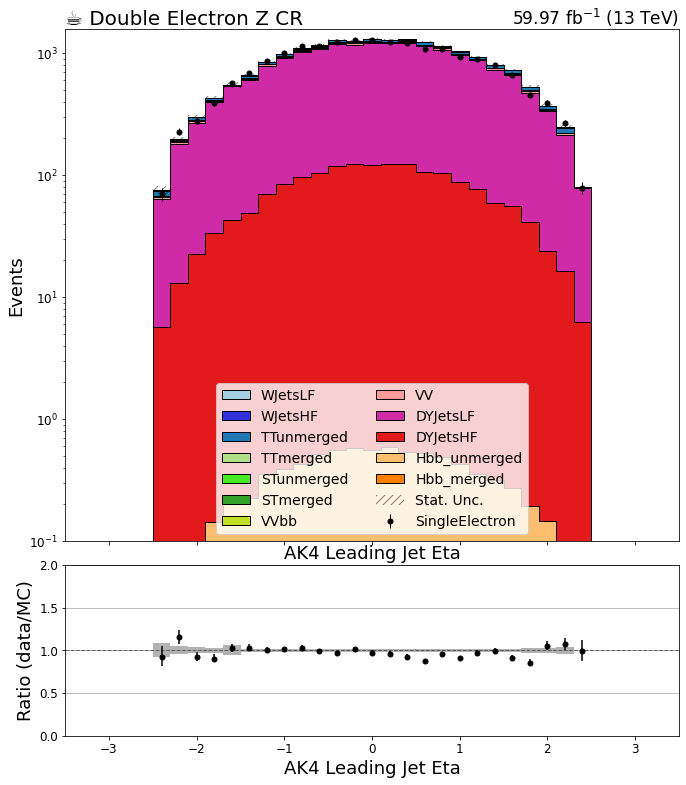

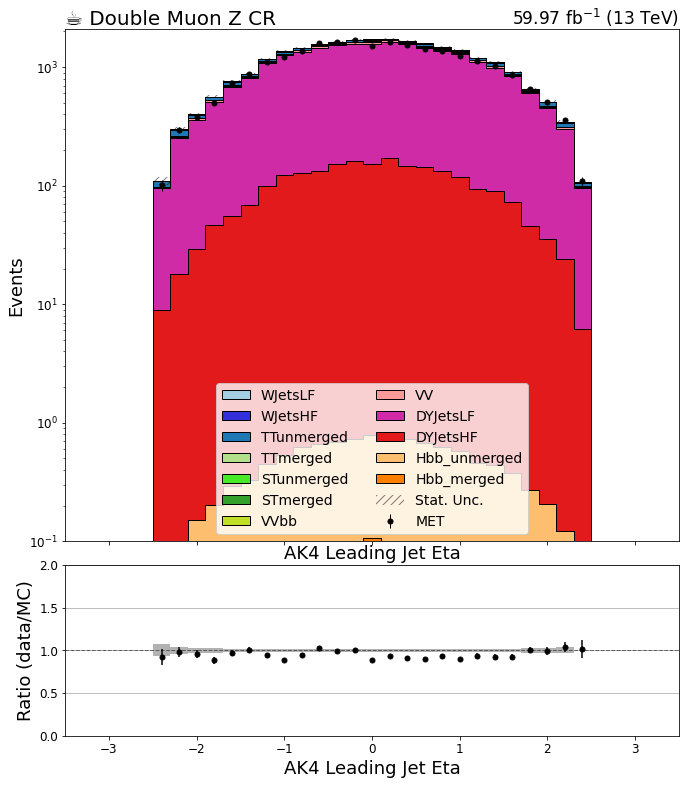

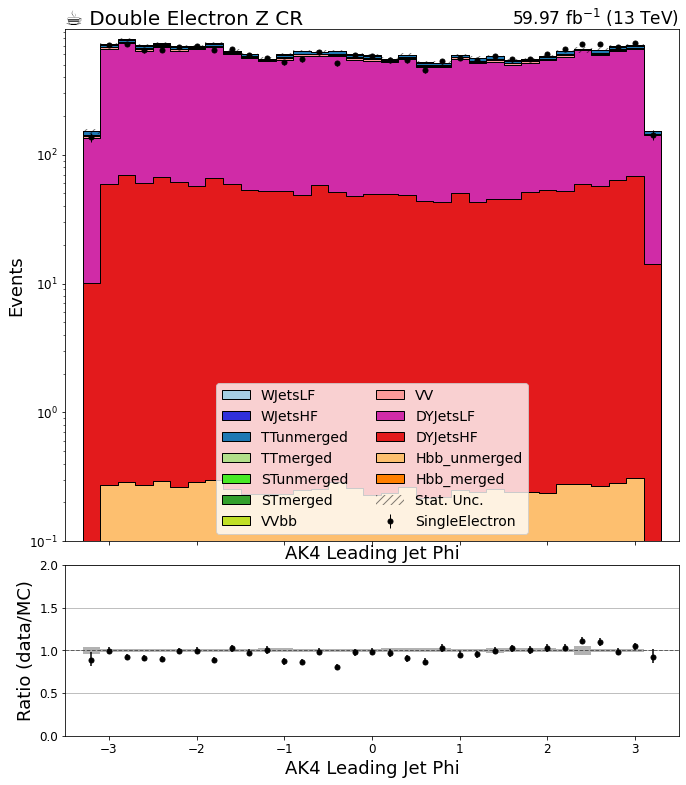

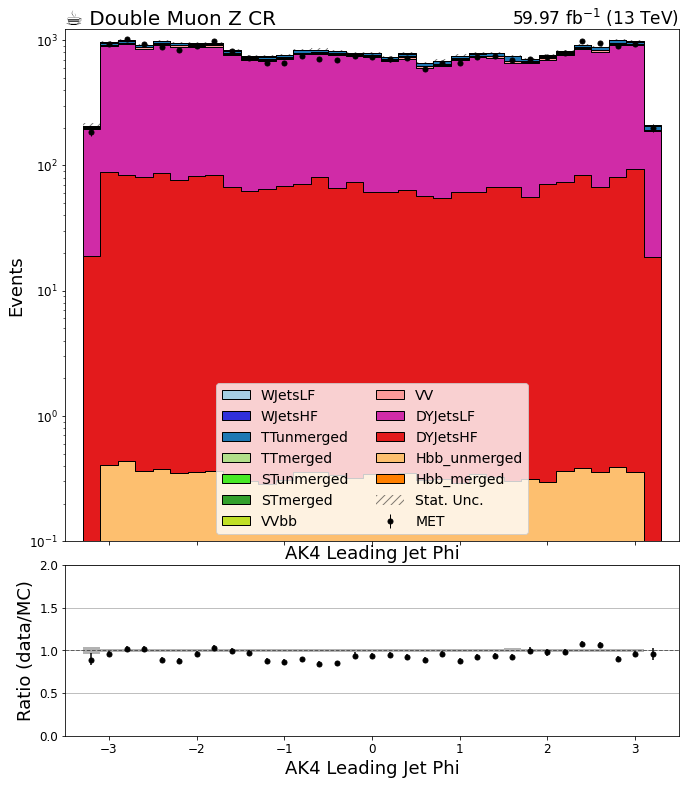

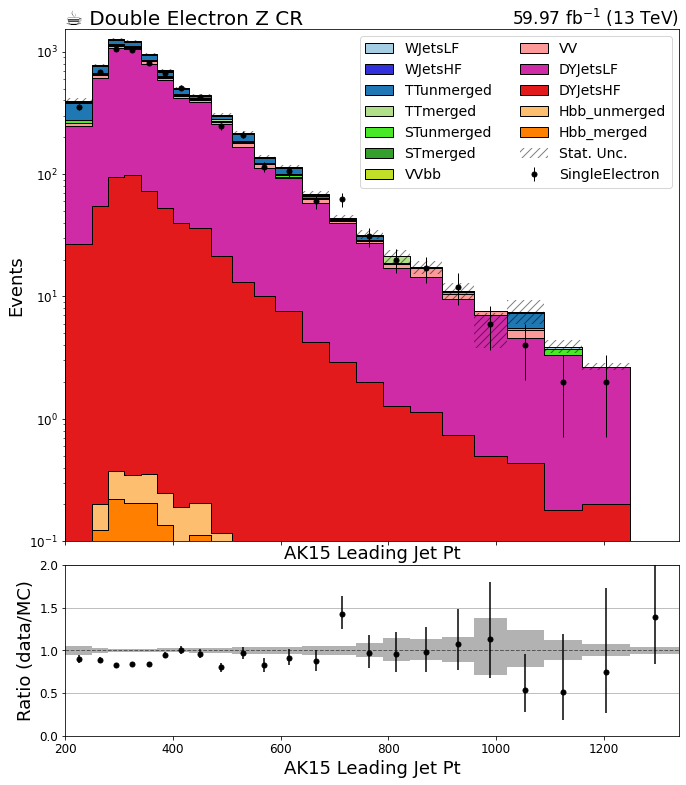

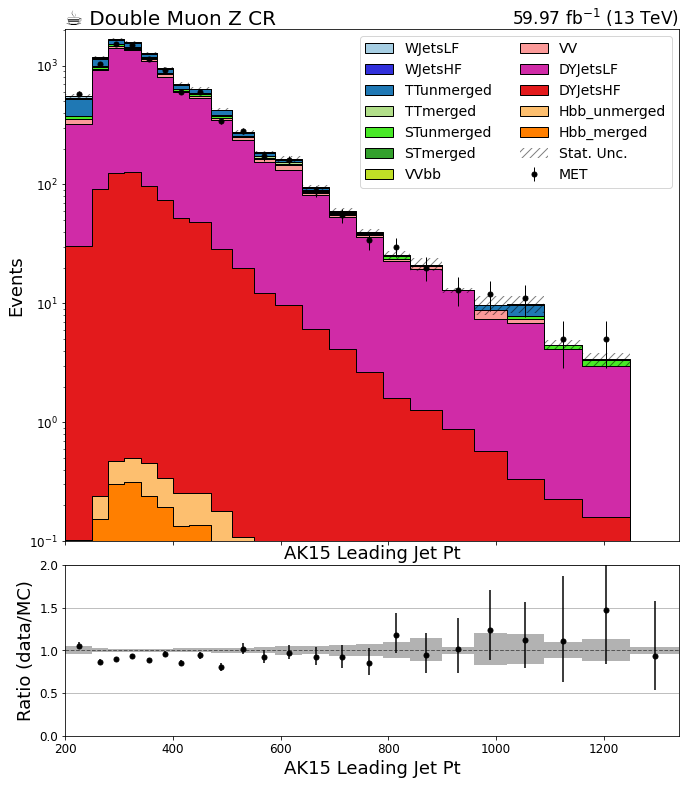

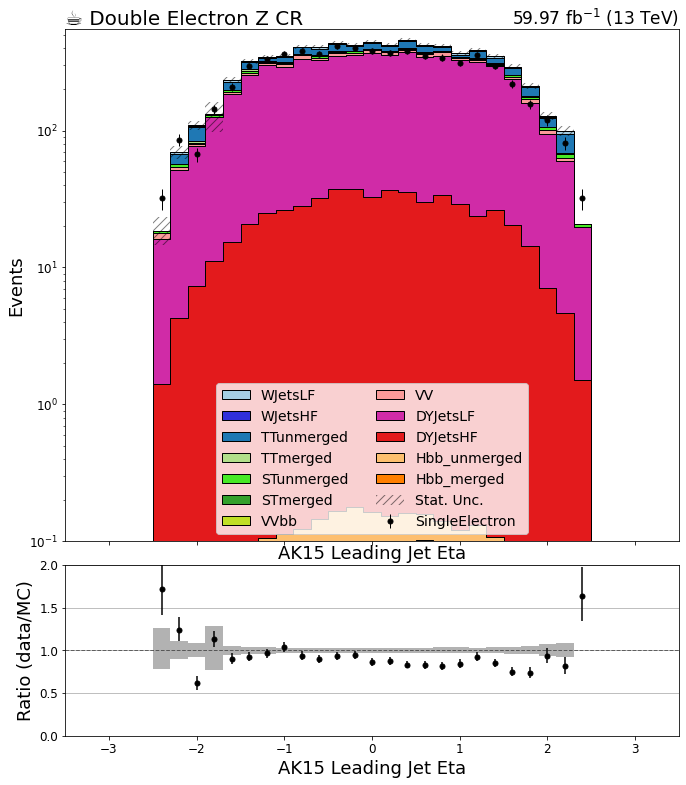

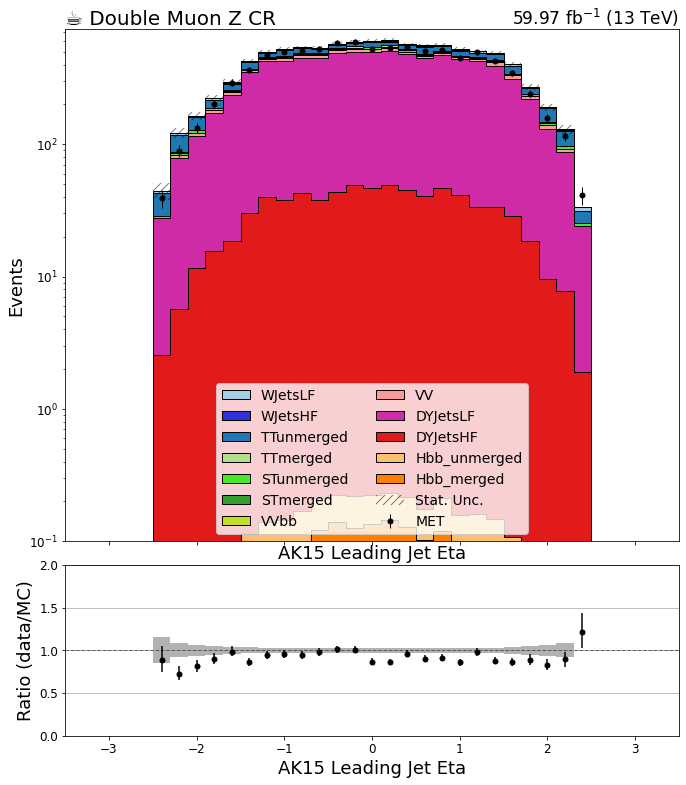

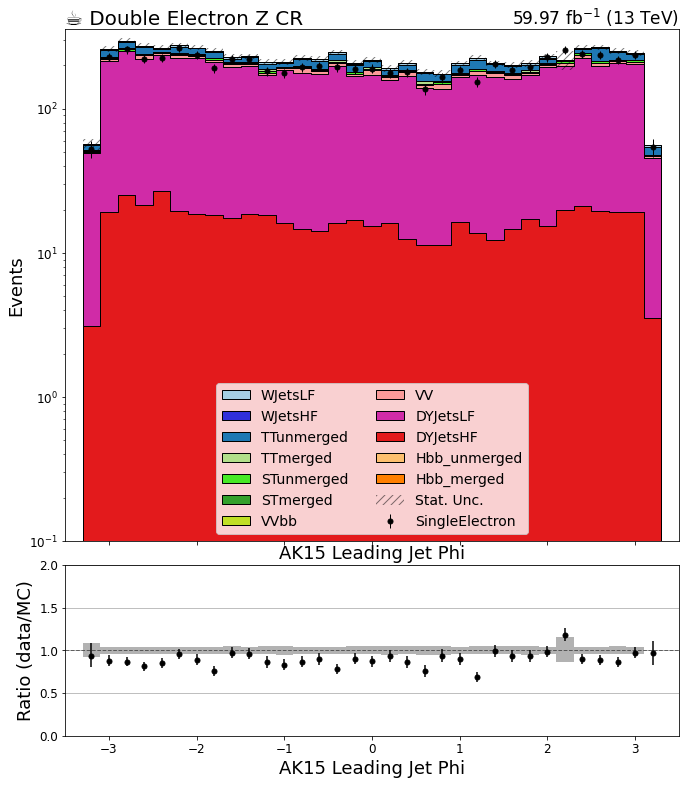

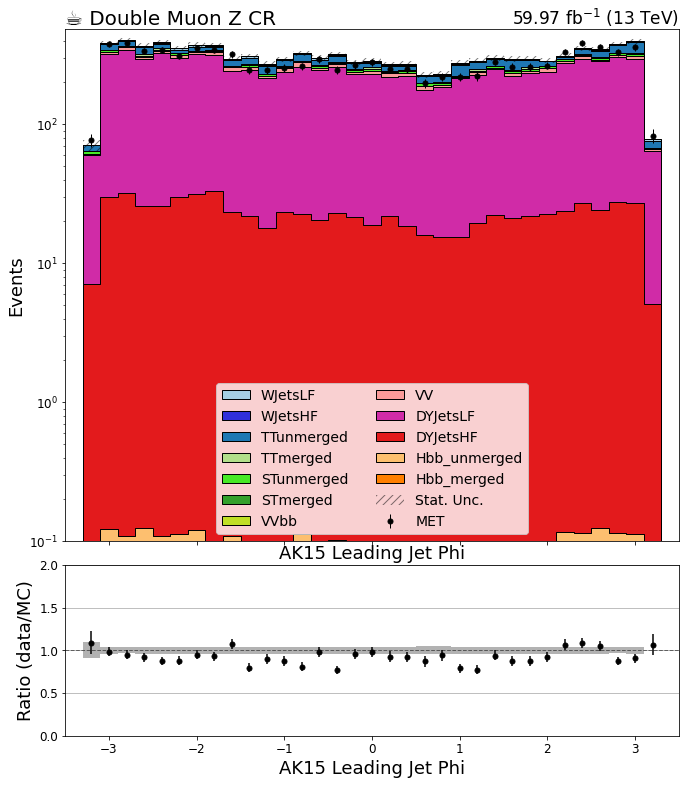

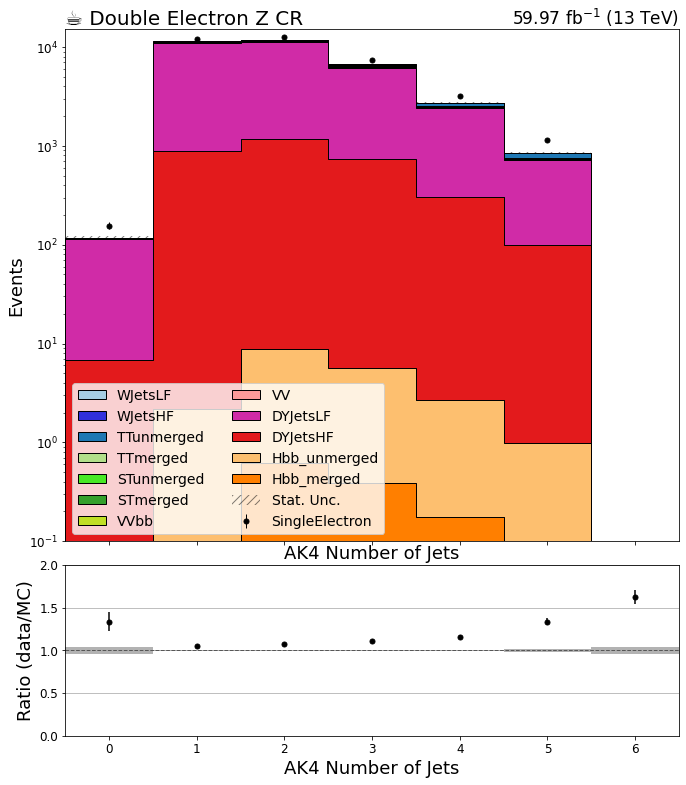

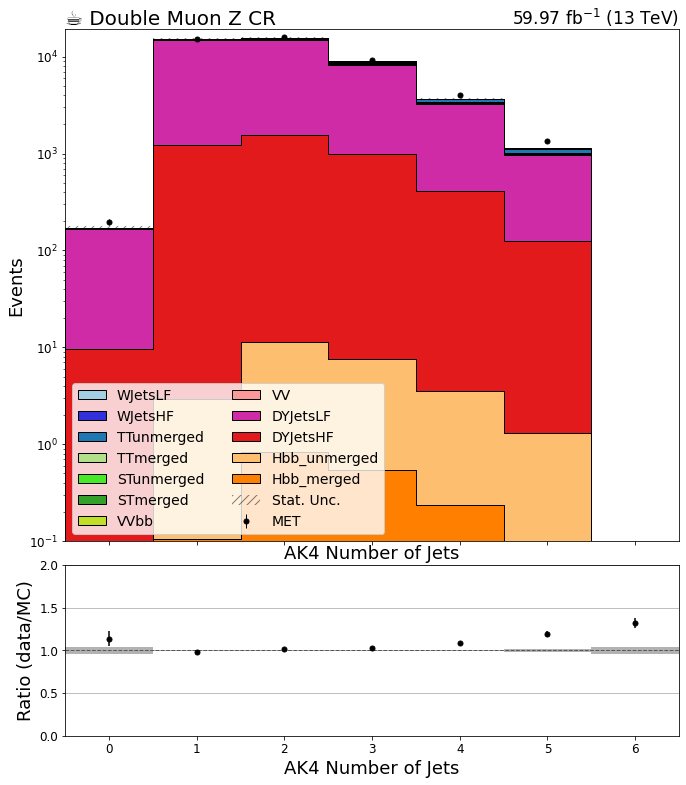

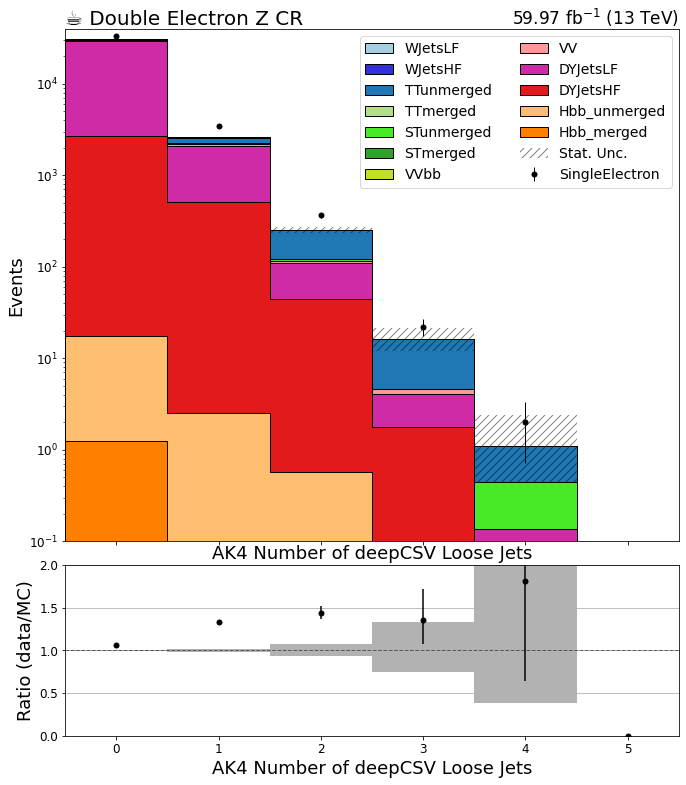

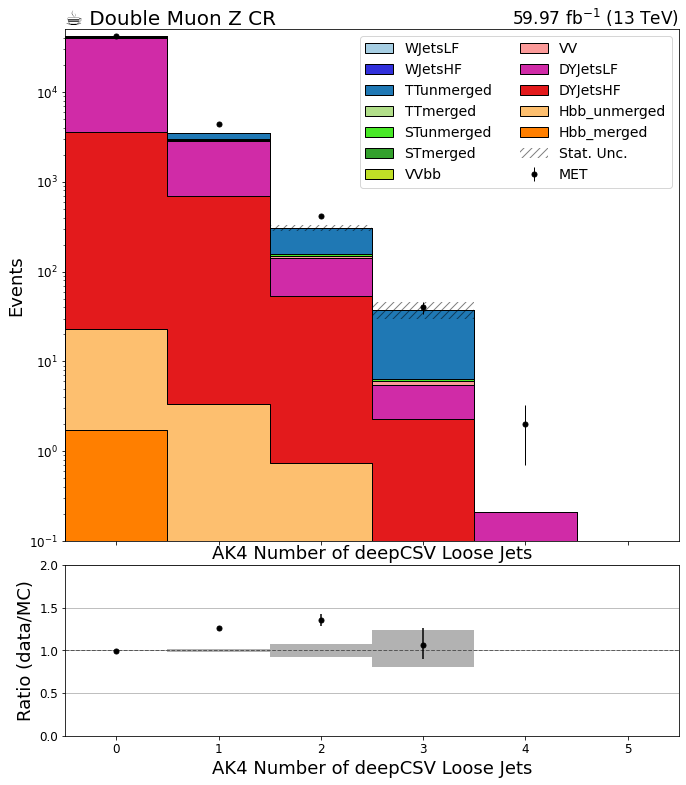

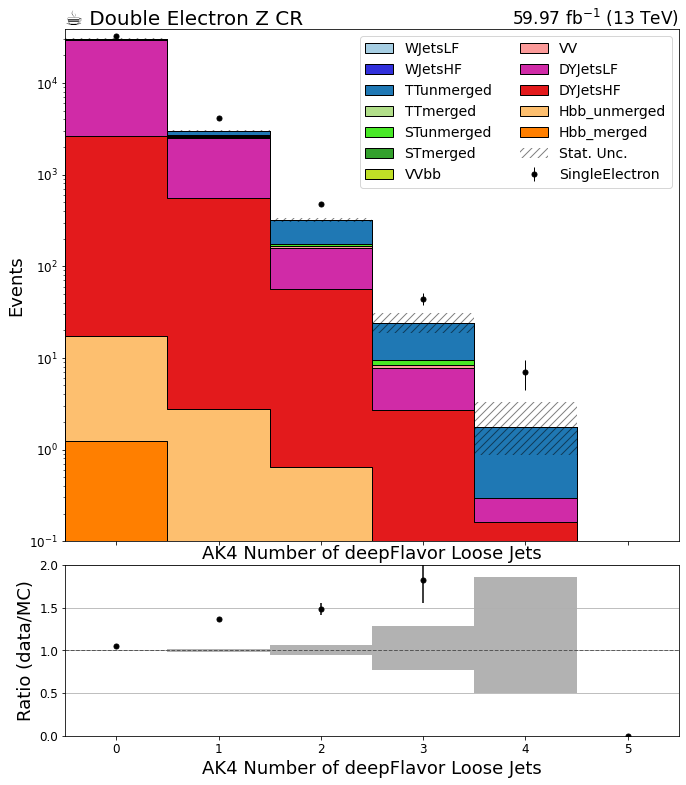

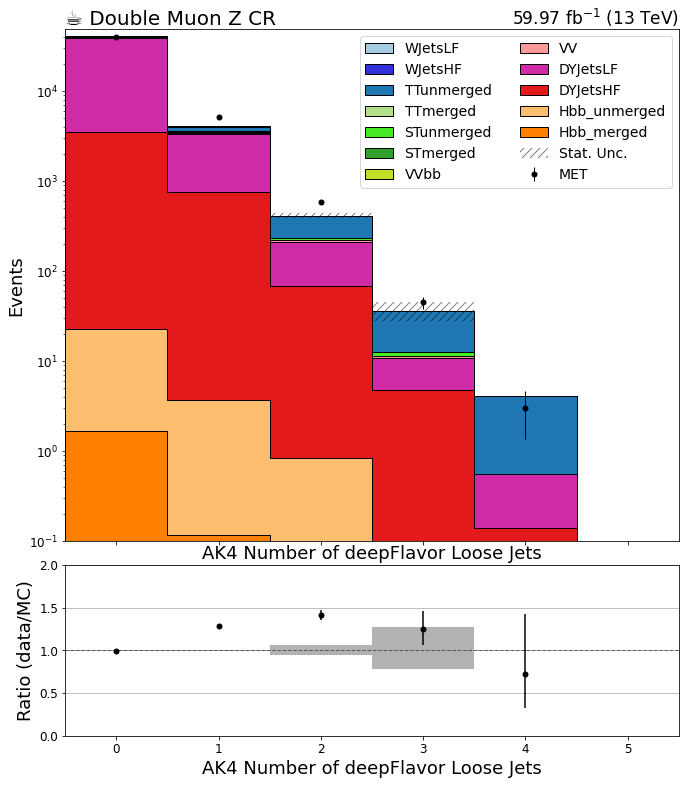

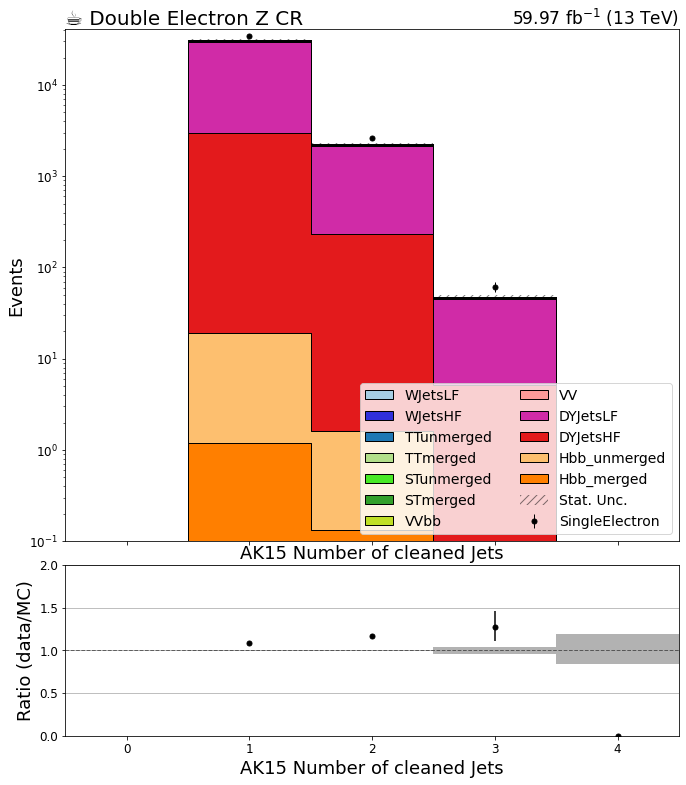

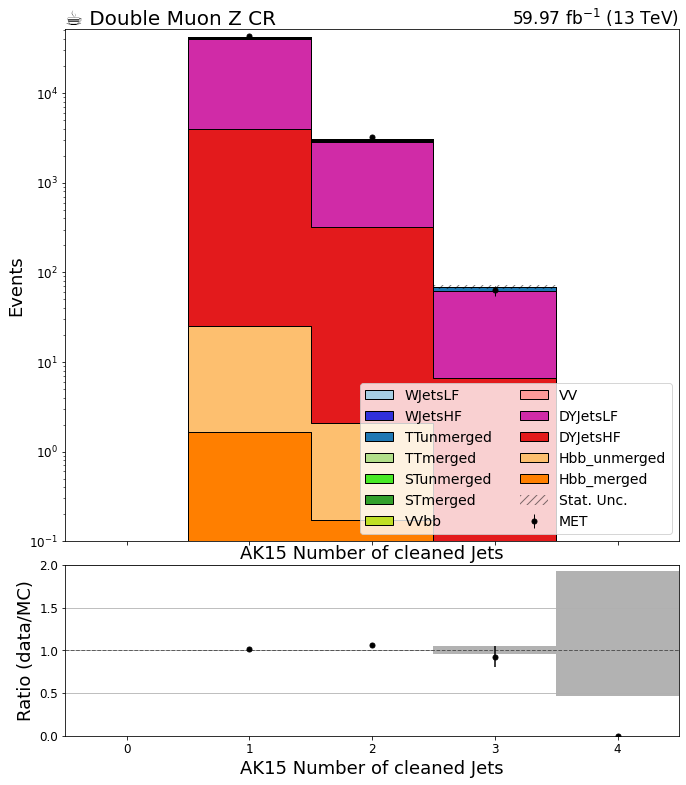

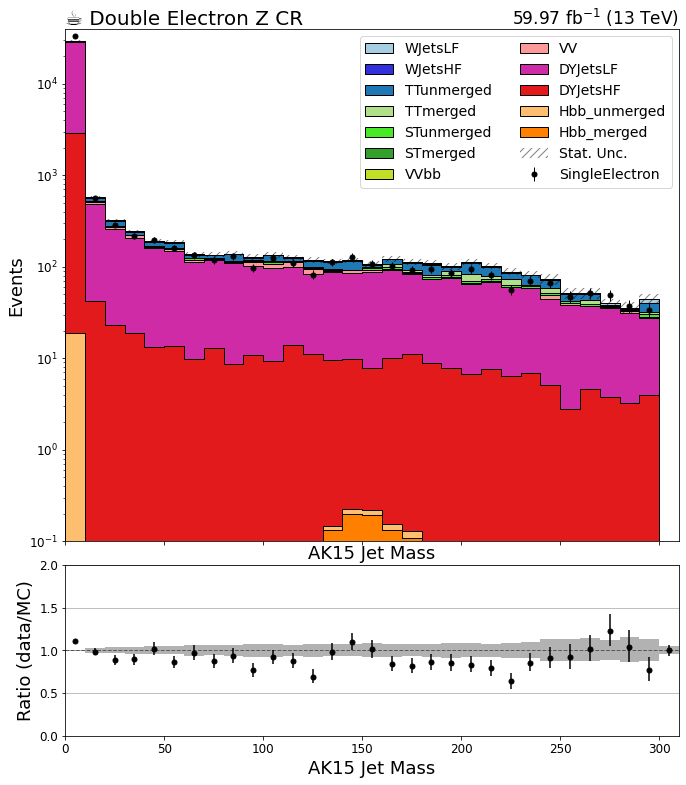

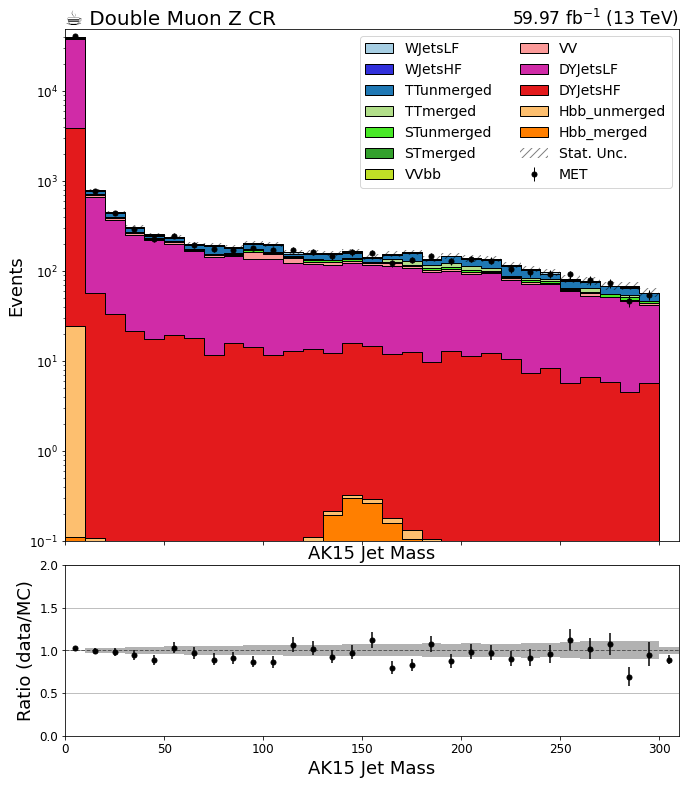

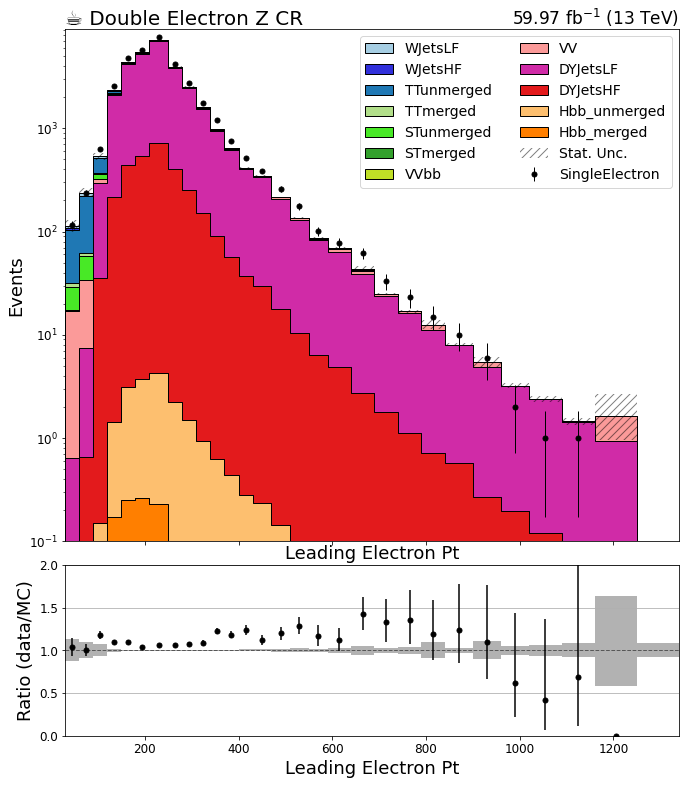

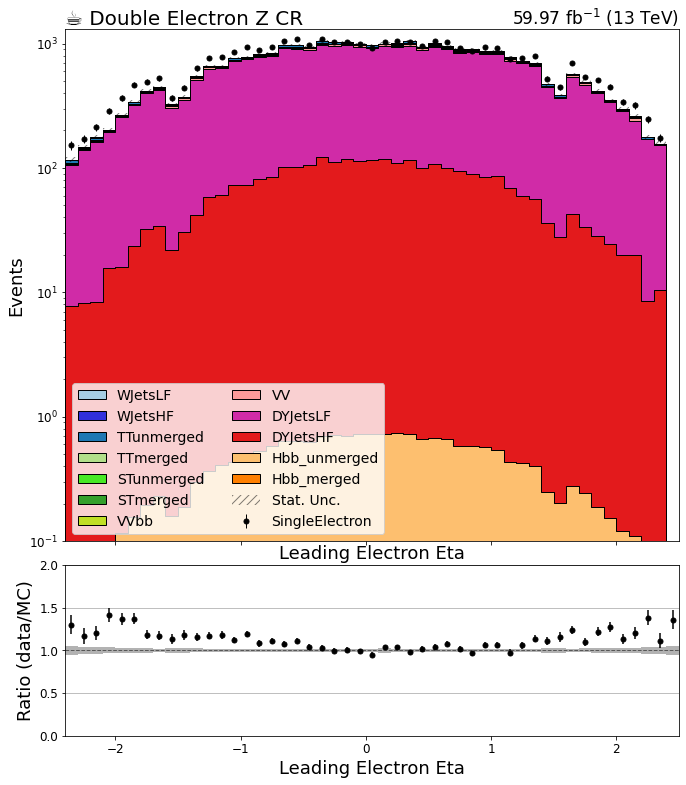

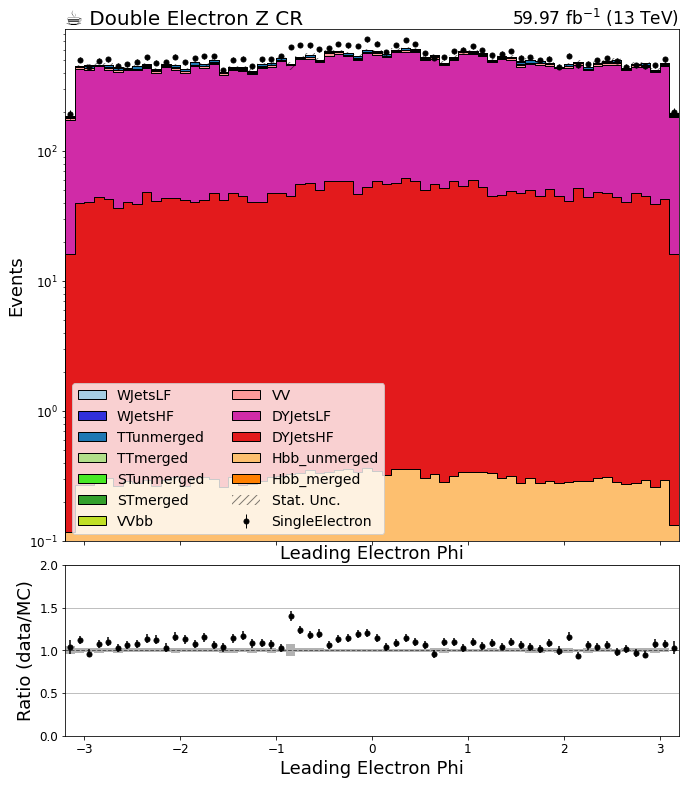

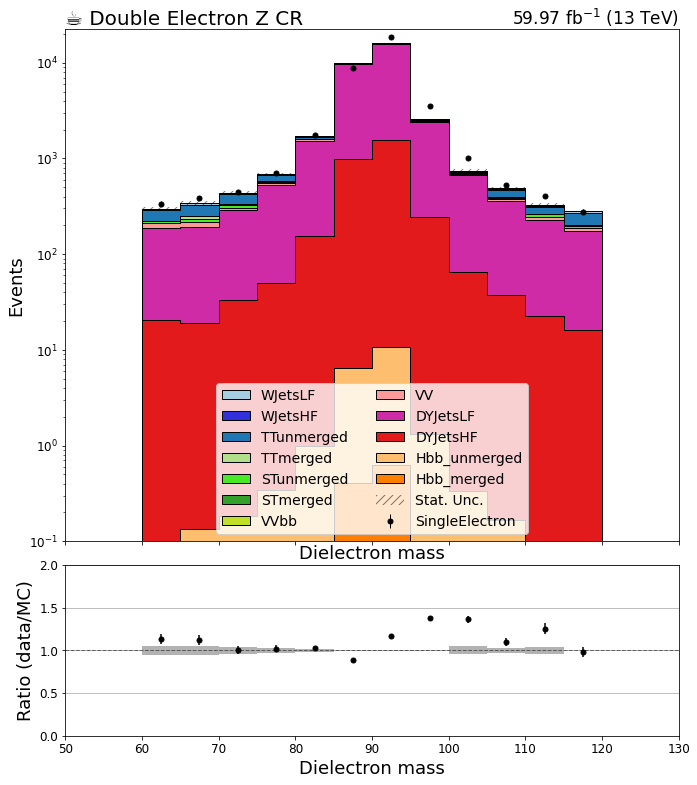

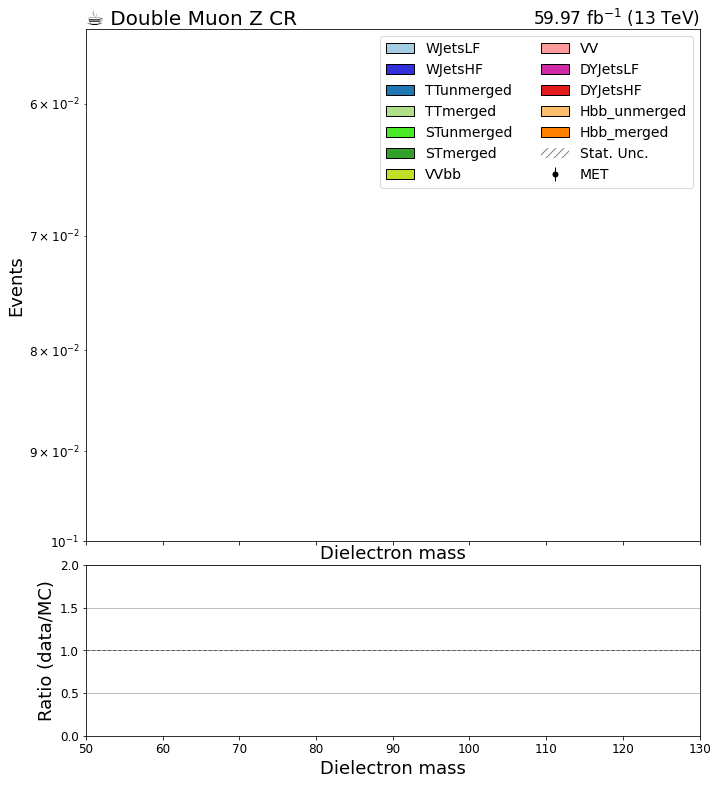

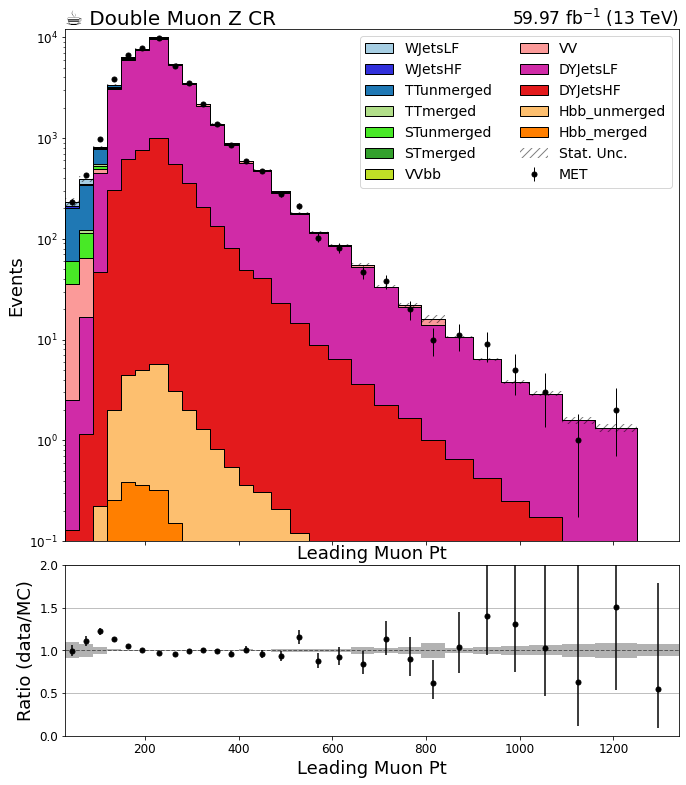

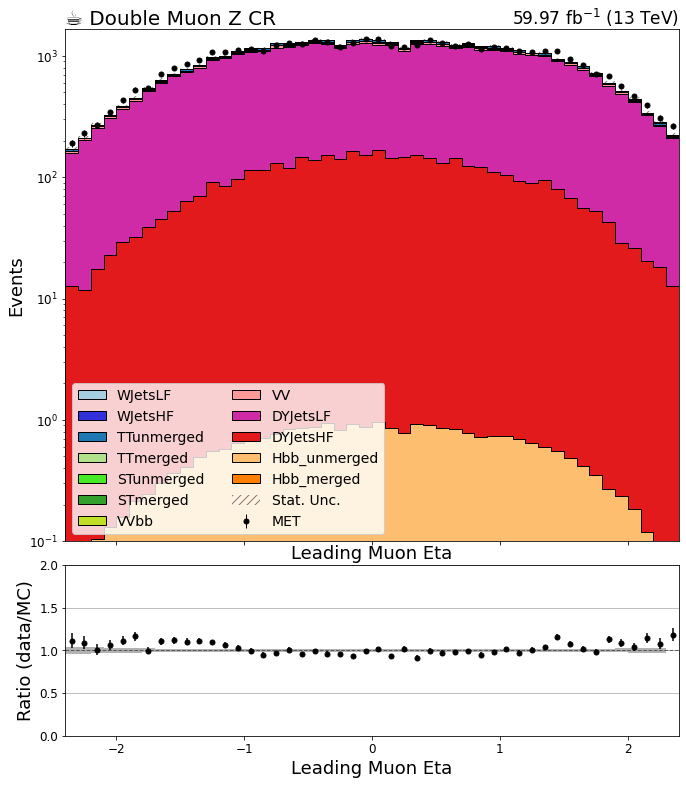

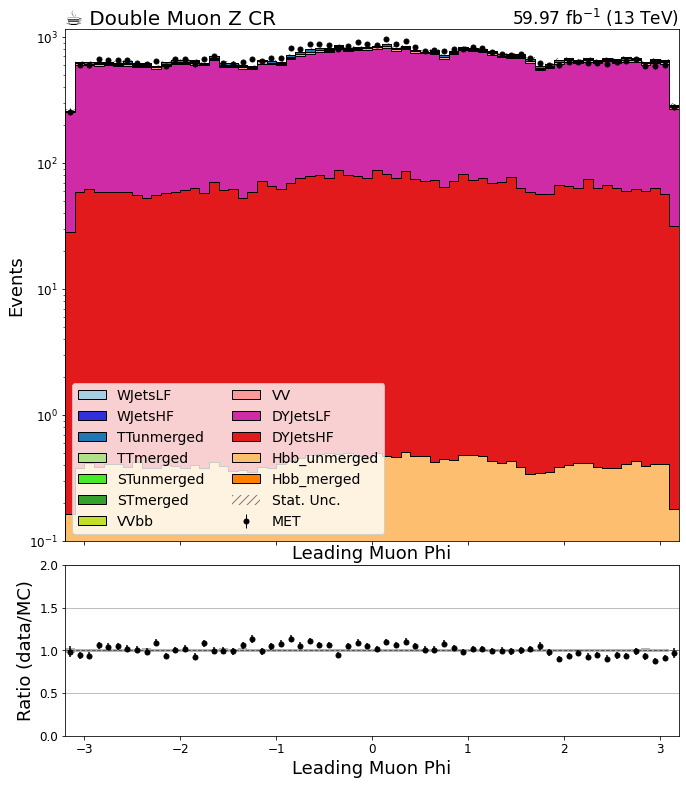

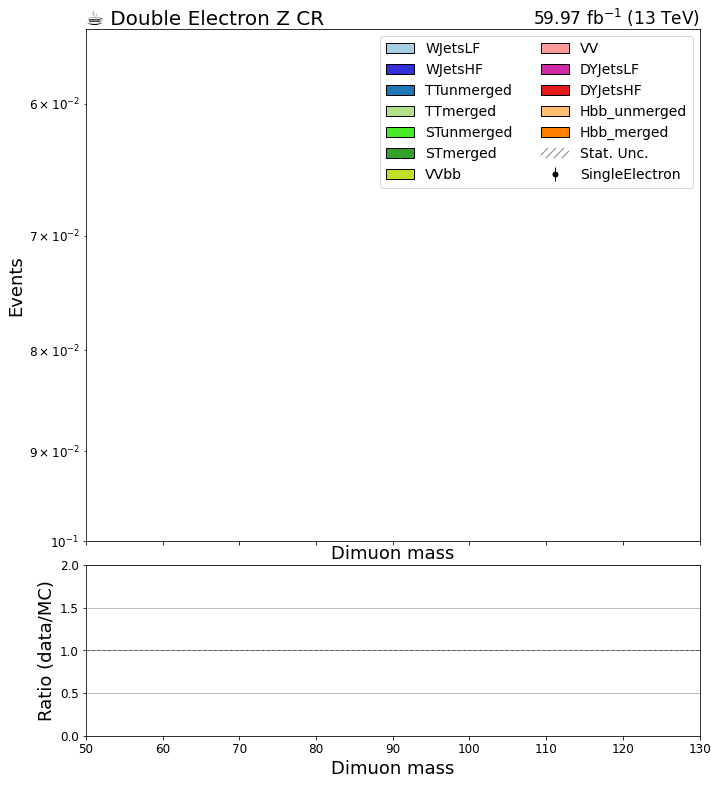

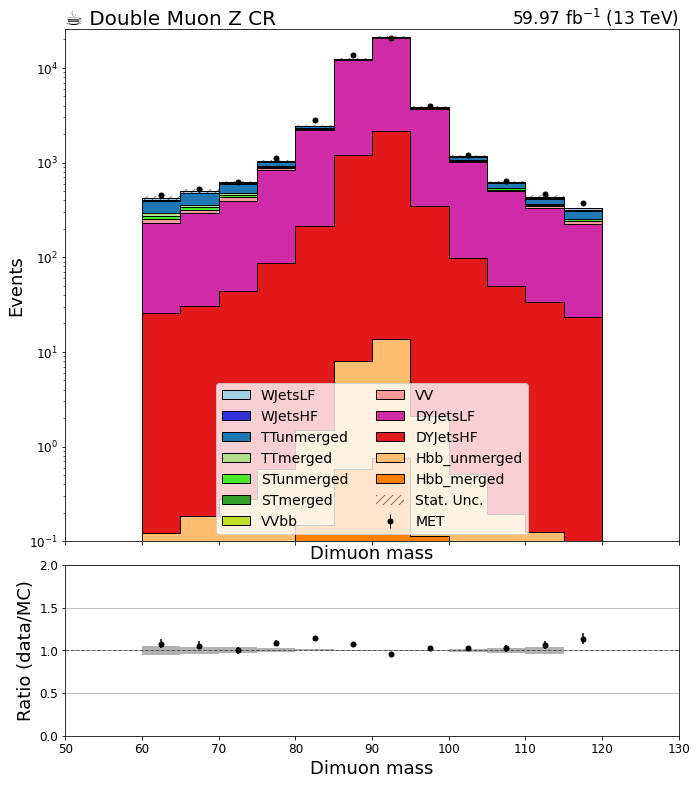

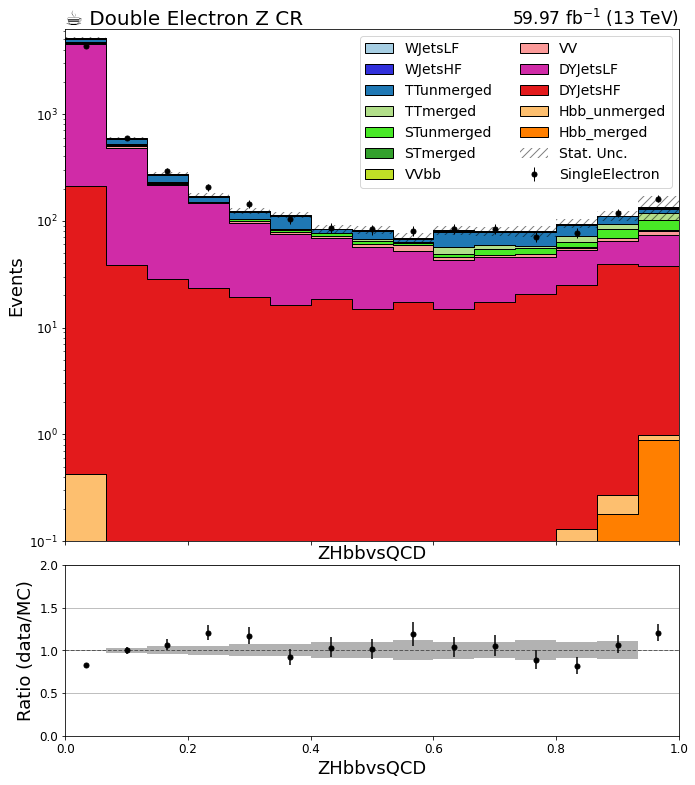

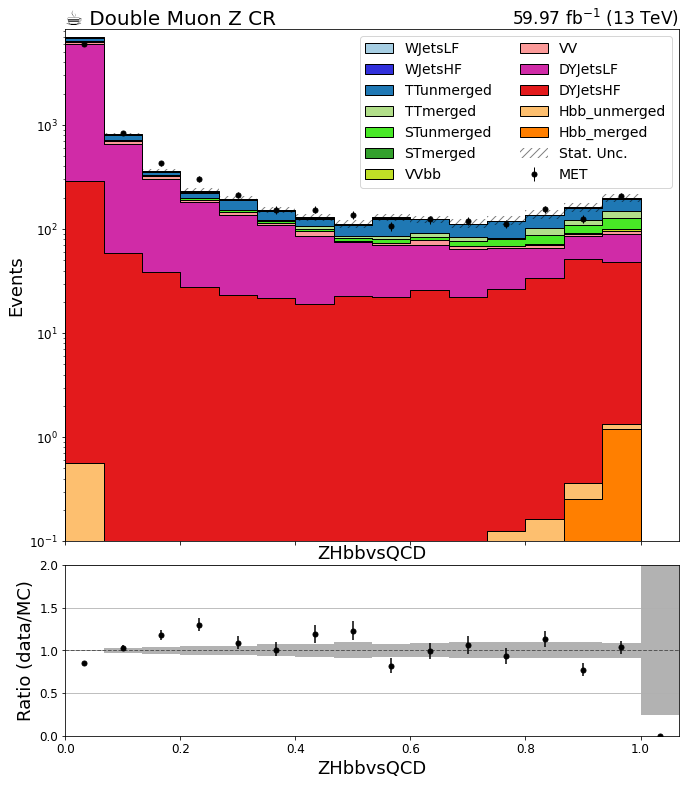

In [5]:
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler


if not os.path.exists('stack'):
    os.makedirs('stack')
    
R = {}
R['sr'] = 'Signal Region'
R['wmcr'] = 'Single Muon W CR'
R['tmcr'] = 'Single Muon Top CR'
R['wecr'] = 'Single Electron W CR'
R['tecr'] = 'Single Electron Top CR'
R['zecr'] = 'Double Electron Z CR'
R['zmcr'] = 'Double Muon Z CR'
R['gcr'] = 'Single Photno CR'

sys = 'nominal'

for key in bkg_hists.keys():
    if key=='sumw': continue
    #if not (key == 'e1pt' or key == 'e1eta'): continue 
   
    for j in bkg_hists[key].identifiers('region'):
        
        if not (str(j) == 'zmcr' or str(j) == 'zecr'): continue
        #if 'mass' in str(j): continue
        #if 'mono' in str(j): continue
        #if str(j) == 'sr' or str(j) == 'gcr': continue
        #if 'ecr' in str(j): continue
        #if str(j) == 'wmcr' or str(j) == 'tmcr' or str(j) == 'wecr' or str(j) == 'tecr':
        #    if key == 'dielemass' or key == 'dimumass': continue
        if str(j) == 'wmcr' or str(j) == 'tmcr' or str(j) == 'zmcr':
            if key == 'e1pt' or key == 'e1eta' or key == 'e1phi': continue
        if str(j) == 'wecr' or str(j) == 'tecr' or str(j) == 'zecr':
            if key == 'mu1pt' or key == 'mu1eta' or key == 'mu1phi': continue
            
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
                  '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
                  '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']


        fig, (ax, rax) = plt.subplots(2, 1, figsize=(11,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
        fig.subplots_adjust(hspace=.07)
        ax.set_prop_cycle(cycler(color=colors))
        

        plot.plot1d(data_hists[key].integrate('systematic',sys).integrate('region',j)[data[str(j).split('_')[0]]],            
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts
                   )

        plot.plot1d(bkg_hists[key].integrate('systematic',sys).integrate('region',j),
                overlay="process",
                ax=ax,
                clear=False,
                stack=True,
                fill_opts=fill_opts,
                error_opts=error_opts
                   )
        
        plot.plotratio(data_hists[key].integrate('systematic',sys).integrate('region',j).integrate('process',data[str(j).split('_')[0]]), 
                   bkg_hists[key].integrate('systematic',sys).integrate('region',j).sum('process'),
                   ax=rax,
                   overflow='over',
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num'
                   )
        
        rax.set_ylabel('Ratio (data/MC)')
        rax.set_ylim(0.0,2.0)
        rax.grid(axis='y')
        
        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        if(key=='dielemass' or key=='dimumass'): ax.set_xlim(50, 130)
        ax.set_ylim(.1, None)
        leg = ax.legend(ncol=2, loc='best')
        
        coffee = plt.text(0., 1., u"☕ "+R[str(j).split('_')[0]], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        lumi = plt.text(1., 1., r"59.97 fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
        plot_path = os.path.abspath('stack') 
        plot_name = 'stack_'+key+'_'+R[str(j).split('_')[0]]+'.png'
        #fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
#### Gamma CR ####

#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler


if not os.path.exists('unstack'):
    os.makedirs('unstack')
    
R = {}
R['sr'] = 'Signal Region'
R['wmcr'] = 'Single Muon W CR'
R['tmcr'] = 'Single Muon Top CR'
R['wecr'] = 'Single Electron W CR'
R['tecr'] = 'Single Electron Top CR'
R['zecr'] = 'Double Electron Z CR'
R['zmcr'] = 'Double Muon Z CR'
R['gcr'] = 'Single Photon CR'

sys = 'nominal'

for key in bkg_hists.keys():
    if key=='sumw': continue

    
    for j in bkg_hists[key].identifiers('region'):
        
        if not str(j) == 'gcr': continue
        #if 'mass' in str(j): continue
        #if 'mono' in str(j): continue
        #if not str(j) == 'gcr': continue
        #if str(j) == 'sr' or str(j) == 'gcr': continue
        #if str(j) == 'wmcr' or str(j) == 'tmcr' or str(j) == 'wecr' or str(j) == 'tecr':
        #    if key == 'dielemass' or key == 'dimumass': continue
            
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        colors = ['#e41a1c', '#377eb8']
        #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        #colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']


        fig, (ax, rax) = plt.subplots(2, 1, figsize=(11,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
        fig.subplots_adjust(hspace=.07)
        ax.set_prop_cycle(cycler(color=colors))
        

        plot.plot1d(data_hists[key].integrate('systematic',sys).integrate('region',j)[data[str(j)]],            
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts
                   )

        plot.plot1d(bkg_hists[key].integrate('systematic',sys).integrate('region',j),
                overlay="process",
                ax=ax,
                clear=False,
                stack=False,
                fill_opts=fill_opts,
                error_opts=error_opts
                   )
        
        plot.plotratio(data_hists[key].integrate('systematic',sys).integrate('region',j).integrate('process',data[str(j)]), 
                   bkg_hists[key].integrate('systematic',sys).integrate('region',j).sum('process'),
                   ax=rax,
                   overflow='over',
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num'
                   )
        
        rax.set_ylabel('Ratio (data/MC)')
        rax.set_ylim(0.0,2.0)
        rax.grid(axis='y')
        
        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        if(key=='dielemass' or key=='dimumass'): ax.set_xlim(50, 130)
        ax.set_ylim(.1, None)
        leg = ax.legend(ncol=2, loc='best')
        
        coffee = plt.text(0., 1., u"☕ "+R[str(j)], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        plot_path = os.path.abspath('unstack')
        plot_name = 'unstack'+key+'_'+R[str(j)]+'.png'
        #fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
process = hist.Cat("process", "Process", sorting='placement')
cats = ("process",)

signal_hists = {}
bkg_hists = {}
data_hists = {}

bkg_map = OrderedDict()
#bkg_map["Hbb_merged"] = ("Hbb_merged*",)
#bkg_map["Hbb_unmerged"] = ("Hbb_unmerged*",)
#bkg_map["DYJetsHF"] = ("DYJetsHF*",)
#bkg_map["DYJetsLF"] = ("DYJetsLF*",)
#bkg_map["VV"] = ("VV",)
#bkg_map["VVbb"] = ("VVbb*",)
#bkg_map["STmerged"] = ("ST_merged*",)
#bkg_map["STunmerged"] = ("ST_unmerged*",)
#bkg_map["TTmerged"] = ("TT_merged*",)
#bkg_map["TTunmerged"] = ("TT_unmerged*",)
#bkg_map["WJetsHF"] = ("WJetsHF*",)
#bkg_map["WJetsLF"] = ("WJetsLF*",)
#bkg_map["ZJetsHF"] = ("ZJetsHF*",)
#bkg_map["ZJetsLF"] = ("ZJetsLF*",)
#bkg_map["GJetsHF"] = ("GJetsHF*",)
#bkg_map["GJetsLF"] = ("GJetsLF*",)
bkg_map["TT"] = ("TT*",)
bkg_map["DY"] = ("DY*",)

signal_map = OrderedDict()
signal_map["Mhs_50_merged"] = ("Mhs_50_merged*",)  ## signals
signal_map["Mhs_50_unmerged"] = ("Mhs_50_unmerged*",)  ## signals   
signal_map["Mhs_70_merged"] = ("Mhs_70_merged*",)
signal_map["Mhs_70_unmerged"] = ("Mhs_70_unmerged*",)
signal_map["Mhs_90_merged"] = ("Mhs_90_merged*",)
signal_map["Mhs_90_unmerged"] = ("Mhs_90_unmerged*",)
signal_map["MonoJet"] = ("MonoJet*",)  ## signals                                                                                                                                                              
signal_map["MonoW"] = ("MonoW*",)    ## signals                                                                                                                                                                
signal_map["MonoZ"] = ("MonoZ*",)    ## signals    

data_map = OrderedDict()
data_map["MET"] = ("MET*", )
data_map["SingleElectron"] = ("SingleElectron*", )
data_map["SinglePhoton"] = ("SinglePhoton*", )


for key in hists.keys():                                                                                                                            
    bkg_hists[key] = hists[key].group(cats, process, bkg_map)  
    signal_hists[key] = hists[key].group(cats, process, signal_map)
    data_hists[key] = hists[key].group(cats, process, data_map)

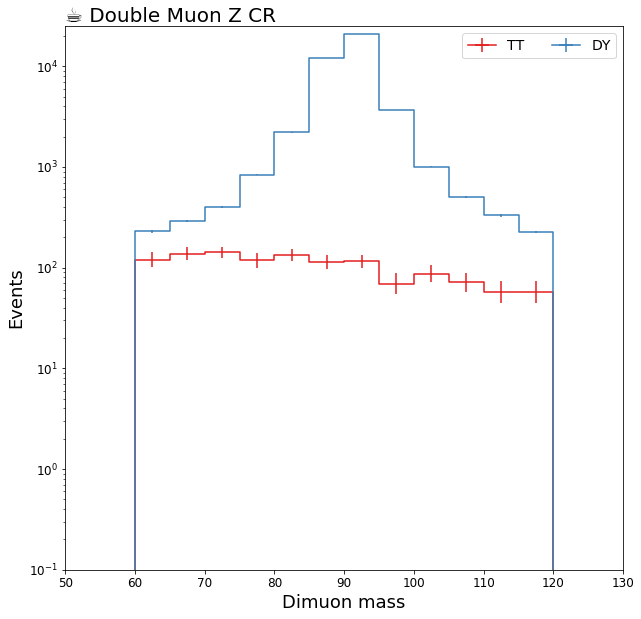

In [13]:
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler


if not os.path.exists('unstack'):
    os.makedirs('unstack')
    
R = {}
R['sr'] = 'Signal Region'
R['wmcr'] = 'Single Muon W CR'
R['tmcr'] = 'Single Muon Top CR'
R['wecr'] = 'Single Electron W CR'
R['tecr'] = 'Single Electron Top CR'
R['zecr'] = 'Double Electron Z CR'
R['zmcr'] = 'Double Muon Z CR'
R['gcr'] = 'Single Photon CR'

sys = 'nominal'

for key in bkg_hists.keys():
    #if key=='sumw': continue
    if 'dimumass' not in key: continue

    
    for j in bkg_hists[key].identifiers('region'):
        
        #if not str(j) == 'gcr': continue
        if 'zmcr' not in str(j): continue
        if 'mass' in str(j): continue
        if 'mono' in str(j): continue
        #if 'dimumass' not in key: continue
            
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
        #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        #colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        fig.subplots_adjust(hspace=.07)
        ax.set_prop_cycle(cycler(color=colors))

        plot.plot1d(bkg_hists[key].integrate('systematic',sys).integrate('region',j),
                overlay="process",
                ax=ax,
                clear=False,
                stack=False,
                   )

        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        if(key=='dielemass' or key=='dimumass'): ax.set_xlim(50, 130)
        ax.set_ylim(.1, None)
        leg = ax.legend(ncol=2, loc='best')
        
        coffee = plt.text(0., 1., u"☕ "+R[str(j).split('_')[0]], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        plot_path = os.path.abspath('unstack')
        plot_name = 'unstack'+key+'_'+R[str(j).split('_')[0]]+'.png'
        #fig.savefig(os.path.join(plot_path, plot_name))